In [297]:
# from core import readfiles
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize, guvectorize, cuda
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_vectors import *
import pickle
import scipy.stats as st
import scipy.interpolate as interp
# import torch
# from core import weights

In [298]:
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator, NullLocator
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator,LogitLocator,NullFormatter,FixedLocator)
import matplotlib

In [299]:
num_threads = int(mul.cpu_count()*0.9)
set_num_threads(num_threads)

In [300]:
len(lhsaao1dec)

75

In [301]:
# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall

# enus = 0.5*(all_enu[1:]+all_enu[:-1])
# UNCOMMENT FOR DENSER LOGARITHMIC BINS, optimal nbins is 1e6
enus = np.logspace(11.001, 18.999, int(1e6))
#print(e_nu_wall)
#print (np.where(enus>1.58489319e+11))


In [302]:
enus_bin_indices = np.zeros(len(enus), dtype=np.int64)

for i in prange(len(enus)):
    enus_bin_indices[i] = np.digitize(enus[i], e_nu_wall) -1
print (enus_bin_indices)

[ 0  0  0 ... 39 39 39]


In [303]:
msdec
print(dec_nu)

[-90.   -73.74 -66.93 -61.64 -57.14 -53.13 -49.46 -46.05 -42.84 -39.79
 -36.87 -34.06 -31.33 -28.69 -26.1  -23.58 -21.1  -18.66 -16.26 -13.89
 -11.54  -9.21  -6.89  -4.59  -2.29   0.     2.29   4.59   6.89   9.21
  11.54  13.89  16.26  18.66  21.1   23.58  26.1   28.69  31.33  34.06
  36.87  39.79  42.84  46.05  49.46  53.13  57.14  61.64  66.93  73.74
  90.  ]


In [304]:
ladec_bin_indices = np.zeros(p1, dtype=np.int64)
for i in prange(p1):
    ladec_bin_indices[i] = np.digitize(lhsaao1dec[i], dec_nu) - 1
print(ladec_bin_indices)

[45 48 47 42 42 41 46 45 44 45 45 39 34 34 40 29 32 27 31 16 29 19 17 17
 18 19 19 20 20 21 22 22 22 23 24 24 24 25 25 26 27 27 29 27 30 31 31 31
 32 32 33 32 34 35 36 36 37 37 29 38 38 37 39 41 39 40 38 41 41 42 44 45
 46 46 46]


In [305]:
gamma_arr = [-2, -2.0, -2.53, -3]
phio = np.logspace(-38, -20, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

# print("\nNumber of threads: ", num_threads)
print("\nNumber of energy bins: ",len(enus))
print("\nNumber of phi bins: ", len(phio))
print("\nCalculating weights...\n\n")


Number of energy bins:  1000000

Number of phi bins:  1000

Calculating weights...




In [306]:
eareaa = [i.astype(np.float64) for i in earea]
eareaa = np.asfarray(eareaa, dtype=np.float64)
print(eareaa.shape)
eareaa[0][0]
earea2 = np.asfortranarray(earea)
earea2 = earea2[0].astype(np.float64)

(5, 2000)


In [307]:
@vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
def psr_wt_sing_gamma(psrno,gamma, season):

    tt_upt = t_upt[season]
    l = ladec_bin_indices[psrno]
    wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)   


    return np.trapz(wt_ac_temp, enus)


In [156]:
ea_season(5)

4

In [308]:
w_models = np.column_stack([np.ones(p1)]).T.astype(np.float64)
sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]
print(w_models.shape)
print(w_models[0])

(1, 75)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]


/tmp/ipykernel_2549/1511017378.py:2: RuntimeWarning: divide by zero encountered in divide
  sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]


In [309]:


print(w_models[-1])
altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
print(os.listdir(altier_path[0]))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
['all_TSS_1000000_bins.pkl', 'wt_acc_1000000_bins.pkl', 'all_Si_ws_g_s_1000000_bins.pkl', 'ns_all_ws_1000000_bins.pkl', 'all_Bi.pkl']


In [310]:
altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
if f'wt_acc_{len(enus)}_bins.pkl' in os.listdir(altier_path[0]):# or f'wt_acc.pkl_{len(enus)}' in os.listdir(altier_path[1]):
    print("Loading wt_acc from pickle")
    # try:
    #     wt_acc = pickle.load(altier_path[1] + f'wt_acc.pkl_{len(enus)//2}_bins')
    # except:
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'rb') as f:
        wt_acc = pickle.load(f)
    
    
    print("Loaded wt_acc from pickle with nbins= ", len(enus))

else:
    print("Calculating wt_acc for all pulsars and seasons and gamma")
    wt_acc = []
    for gamma in prange(len(gamma_arr)):
        wt_allpsr = []
        for season in tqdm(prange(10)):
            # tmp = []
            # for psrno in prange(p):
                # w_model = w_models[psrno]
                # tmp.append(psr_wt_sing_gamma(psrno, gamma_arr[gamma], season))
                # tmp.append(trapz_numba(psr_wt_sing_e_gamma(psrno, enus, gamma_arr[gamma], season), enus))

            wt_allpsr.append(np.array(psr_wt_sing_gamma(prange(p1), gamma_arr[gamma], season), dtype=np.float64))
            # tmp = []
        wt_acc.append(wt_allpsr)
        wt_allpsr = []
        
    wt_acc = np.asfarray(wt_acc, dtype=np.float64)
    print
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(wt_acc, f)
    print("Calculated wt_acc for all gamma-ray sources and seasons and gamma")

Loading wt_acc from pickle
Loaded wt_acc from pickle with nbins=  1000000


In [311]:
print(wt_acc[0][9].shape)

(75,)


In [312]:
season_walls = np.asarray([0, 36900, 143911, 237044, 373288, 486146, 608687, 735732, 865043, 988700, 1134450])
season_widts= np.diff(season_walls)
print (season_widts)

[ 36900 107011  93133 136244 112858 122541 127045 129311 123657 145750]


In [313]:
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

@njit(nogil=True)
def S_ijk(nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(lhsaao1ra, lhsaao1dec, icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2


@njit(nogil=True)
def S_ik(nu, weight, w_models, gamma_index, ws):

    '''
    
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample

    normalized_wt : array
        Normalized weights of the pulsars


    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino

    '''

    # si_sing_season_g =
    # for i in prange(p):
        # sij = S_ijk(nu)
        # np.sum(np.multiply(sij, normalized_wt[i][gamma_index][season]))      #1/rad**2



    sij = S_ijk(nu)
    season = 0
    for i in range(10):
        if season_walls[i] <= nu and nu < season_walls[i+1]:
            season = i
            break

    return np.sum(np.multiply(sij, np.multiply(w_models[ws], weight[gamma_index][season])/np.sum(np.multiply(w_models[ws], weight[gamma_index][season]))))      #1/rad**2

In [314]:
@njit(parallel=True, nogil=True)
def Sik_sing_s_g(gamma_index, ws):#, wt_acc=wt_acc, w_models=w_models):
    '''
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    weight : array
         weights of the pulsars

    season : int
        Season of the neutrino

    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''



    tmp = []
    if ws == -1: #No weights
        for nu in prange(len(icra)):
            tmp.append(np.sum(S_ijk(nu)))
        return np.array(tmp, dtype=np.float64)

    for nu in prange(len(icra)):
        tmp.append(S_ik(nu, wt_acc, w_models, gamma_index, ws))
    return np.array(tmp, dtype=np.float64)

In [315]:
#Pickle
if os.path.isfile(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl'):
    print("Loading all_Si_ws_g_s from pickle")
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl', 'rb') as f:
        all_Si_ws_g_s = pickle.load(f)
    print("Loaded all_Si_ws_g_s from pickle with nbins =", len(enus))
else:


    print("\nCalculating S_i for all neutrinos and gammas and weighting schemes...\n")

    all_Si_ws_g_s = []
    #tmp = []
    tmp_wt_acc = []
    #tmp_wt_acc_w_dist = []
    #tmp_wt_acc_w_s1400 = []

    for gamma_index in tqdm(prange(4)):
        # for season in tqdm(prange(10)):
        #tmp.append(Sik_sing_s_g(gamma_index, -1))
        tmp_wt_acc.append(Sik_sing_s_g(gamma_index, 0))
        #tmp_wt_acc_w_dist.append(Sik_sing_s_g(gamma_index, 1))
        #tmp_wt_acc_w_s1400.append(Sik_sing_s_g(gamma_index, 2))


    all_Si_ws_g_s.append([tmp_wt_acc])
    #tmp = []
    tmp_wt_acc = []
    #tmp_wt_acc_w_dist = []
    #tmp_wt_acc_w_s1400 = []
    all_Si_ws_g_s = np.asfarray(all_Si_ws_g_s[0])

    print("Calculated S_i for all neutrinos and gammas and weighting schemes")
    #Save to pickle
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(all_Si_ws_g_s, f)



Loading all_Si_ws_g_s from pickle
Loaded all_Si_ws_g_s from pickle with nbins = 1000000


In [316]:
# @jit(nopython=True)
@vectorize(['float64(int64, int64)'], nopython=True,target='parallel')
def Bi_stacked_compute(nu, cone=5):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    count=0
    for i in prange(len(icdec)):
        if abs(icdec[i] - icdec[nu]) <= cone:
            count+=1
    binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
    return count/(binwidth * N_ic)           #No units or sr**-1

In [317]:
#Pickle
if os.path.isfile(altier_path[0] + f'all_Bi.pkl'):
    print("Loading all_Bi from pickle...")
    with open(altier_path[0] + f'all_Bi.pkl', 'rb') as f:
        all_Bi = pickle.load(f)
    print("Loaded all_Bi from pickle")
else:
    print("\nCalculating Bi for all neutrinos\n")
    all_Bi = Bi_stacked_compute(np.arange(lnu), 5)
    # all_Bi+=1e-90
    print("\nCalculated Bi for all neutrinos")
    #Save to pickle
    with open(altier_path[0] + f'all_Bi.pkl', 'wb') as f:
        pickle.dump(all_Bi, f)

Loading all_Bi from pickle...
Loaded all_Bi from pickle


 '''
    This function returns the number of signal events for a single pulsar as in EQN3 of 2205.15963
    -------------------

    Parameters
    ----------
    dec : float
        The declination of the pulsar in radians
    
    enu : float
        The neutrino energy in eV

    gamma : float
        The spectral index of the neutrino flux

    phi0 : float (optional)
        The normalization constant of the neutrino flux

    season : int (optional)
        The IceCube season number
    
    Returns
    -------
    float
        The number of signal events for the given parameters
    '''


In [318]:
# type(msdec_bin_indices[0])
print (len(all_Bi))

1134450


In [319]:
arr = np.zeros(10, dtype=np.float64)

In [320]:
t_upt

array([35318439.34329611, 32497618.3151043 , 29902901.99932829,
       31745765.00015999, 32053797.00057632, 33098838.99984006,
       34788962.99980783, 33936928.00012794, 31302372.99945645,
       36107635.00003202])

In [321]:
#generates ns^ for a single pulsar a single season and a single energy


# @vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
# def psr_wt_sing_gamma(psrno,gamma, season):

#     tt_upt = t_upt[season]
#     l = msdec_bin_indices[psrno]
#     wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
#     for i in prange(len(enus)):
#         wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)


#     return np.trapz(wt_ac_temp, enus)
# @njit
# @vectorize(['float64(float64, float64, float64, int64)'], target='parallel')
@vectorize(['float64(int64, float64, float64, int64)'], nopython=True, target='parallel')
def ns_singleseason_sing_psr_HAT(psrno,gamma, phi0, season):
   

    tt_upt = t_upt[season]
    # if enu <= 1e11 or enu >= 1e19:
    #     return 0.0
    # else:
        # k=0
    l = ladec_bin_indices[psrno]
        # for i in range(0, len(e_nu_wall)):
        #     if e_nu_wall[i] <= enu and e_nu_wall[i+1] > enu:
        #         k=i
        #         break

        # for j in range(0, len(dec_nu)):
        #     if dec_nu[j] <= dec and dec_nu[j+1] > dec:
        #         l=j
        #         break
    ns_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        ns_temp[i] += np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * phi0 * (enus[i]/(10**14))**gamma)
    # temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
    # return tt_upt * temp_ea * phi0 * ((enu/(10**14))**gamma)     #in s cm2 eV

    return np.trapz(ns_temp, enus)     #in s cm2 eV


In [322]:
def ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma, e_nus=enus, phi0=1):
    # ns_hat = 0
    ns_hat_wt = 0
    # ns_hat_wt_dist = 0
    # ns_hat_wt_s1400 = 0
    for season in tqdm(prange(10)):
        # for psr in prange(p):
            # wt = all_weights[0][gamma_arr.index(gamma)][psr][ea_season(season)]
        wt_sum = np.sum(wt_acc[gamma_arr.index(gamma)][season])

        wt = wt_acc[gamma_arr.index(gamma)][season]
        ns_hat = ns_singleseason_sing_psr_HAT(prange(p1), gamma, phi0, season)
        # ns_hat_wt += np.dot(wt, nsop)
        # ns_hat_wt_dist += np.dot(wt/msdist[prange(p)]**2, nsop)
            # nsop = ns_singleseason_sing_psr_HAT(msdec[psr], e_nus, gamma, phi0, season)
            
            # ns_hat += np.trapz(nsop, x=e_nus)
        
    #         ns_hat_wt += wt * np.trapz(nsop, x=e_nus)
    #         ns_hat_wt_dist += wt * np.trapz(nsop, x=e_nus) / (msdist[psr]**2)
    #         ns_hat_wt_s1400 += wt * np.trapz(nsop, x=e_nus) * mss1400[psr]
    # return np.array([ns_hat, ns_hat_wt, ns_hat_wt_dist, ns_hat_wt_s1400], dtype=np.float64)

        ns_hat_wt += np.dot((wt/wt_sum),  ns_hat)
        # ns_hat_wt_dist += np.dot(wt * w_models[1]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[1])) , ns_hat)
        # ns_hat_wt_s1400 += np.dot(wt * w_models[2]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[2])), ns_hat)
    return np.array([ns_hat_wt], dtype=np.float64)

In [323]:
#Pickle
arr = []
if os.path.isfile(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl'):
    print("Loading ns_hat from pickle...")
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl', 'rb') as f:
        arr = pickle.load(f)
    print("Loaded ns_hat from pickle with nbins =", len(enus))
else:
    print("\nCalculating ns_HAT for all gamma and weighting schemes...\n")

    arr=[]
    for gamma in prange(len(gamma_arr)):
        tmp = ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma_arr[gamma])
        np.savetxt('outputs/ns_hat_wt_wt_gamma_{}.txt'.format(gamma_arr[gamma]), tmp)
        arr.append(tmp)
        tmp = []

    arr = np.array(arr, dtype=np.float64)
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(arr, f)
    print("\nCalculationed ns_HAT for all gamma and weighting schemes")

Loading ns_hat from pickle...
Loaded ns_hat from pickle with nbins = 1000000


In [324]:
arr

array([[1.61193566e+29],
       [1.61193566e+29],
       [4.81876505e+29],
       [2.77758404e+30]])

In [325]:
@njit(parallel=True, nogil=True)
def season_nu(nu):
    for i in prange(10):
        if nu >= season_walls[i] and nu < season_walls[i+1]:
            return i

t2mp = all_Si_ws_g_s[0][0]
nsa = 50
@njit(nogil=True)
def TS_for_all_psrs2(nsa):  
    return Ts_arr2(nsa, t2mp, all_Bi, Ns) 

TS_for_all_psrs2(nsa)

In [326]:
@jit(nopython=True)
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



@njit(nogil=True)
def TS_st_vec(x, S, B, Ns):
    nsN = x/Ns
    pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
    return np.sum(np.asfarray(2*np.log(pr/B)))

lnu = 1134450
Ns = lnu#np.count_nonzero(nuind+1)


TS_st_vec(0.5e6, all_Si_ws_g_s[0][0], all_Bi, Ns)

In [327]:
phio = np.logspace(-38, -20, 1000)
print(phio)

[1.00000000e-38 1.04236067e-38 1.08651577e-38 1.13254132e-38
 1.18051653e-38 1.23052400e-38 1.28264983e-38 1.33698374e-38
 1.39361927e-38 1.45265393e-38 1.51418933e-38 1.57833141e-38
 1.64519059e-38 1.71488197e-38 1.78752553e-38 1.86324631e-38
 1.94217468e-38 2.02444651e-38 2.11020343e-38 2.19959307e-38
 2.29276931e-38 2.38989257e-38 2.49113003e-38 2.59665597e-38
 2.70665207e-38 2.82130768e-38 2.94082017e-38 3.06539530e-38
 3.19524751e-38 3.33060034e-38 3.47168682e-38 3.61874981e-38
 3.77204249e-38 3.93182876e-38 4.09838367e-38 4.27199397e-38
 4.45295851e-38 4.64158883e-38 4.83820966e-38 5.04315949e-38
 5.25679112e-38 5.47947234e-38 5.71158648e-38 5.95353313e-38
 6.20572881e-38 6.46860766e-38 6.74262224e-38 7.02824426e-38
 7.32596543e-38 7.63629826e-38 7.95977700e-38 8.29695852e-38
 8.64842328e-38 9.01477631e-38 9.39664831e-38 9.79469667e-38
 1.02096066e-37 1.06420924e-37 1.10928986e-37 1.15628013e-37
 1.20526094e-37 1.25631660e-37 1.30953502e-37 1.36500781e-37
 1.42283046e-37 1.483102

In [328]:
print('\nCALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS\n')

all_TSS = []
for ws in prange(1):
    tmpp = []
    print("ws = {}".format(ws))
    for gamma in prange(len(gamma_arr)):
        print("gamma = {}".format(gamma))
        # tmp = np.zeros(len(phio))
        # for season in tqdm(range(10)):
        t2mp = np.asfarray(all_Si_ws_g_s[ws][gamma])
        @njit(nogil=True)
        def TS_for_all_psrs2(nsa):  
            return TS_st_vec(nsa, t2mp, all_Bi, Ns)      #No units
        temp = []
        for phi in tqdm(prange(len(phio))):
            temp.append(TS_for_all_psrs2(arr[gamma][ws]*phio[phi]))
        tmpp.append(temp)
        temp = []
    all_TSS.append(tmpp)
    tmpp = []

print('\nCALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS')


CALCULATING TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS

ws = 0
gamma = 0


100%|██████████| 1000/1000 [00:08<00:00, 120.29it/s]


gamma = 1


100%|██████████| 1000/1000 [00:08<00:00, 121.76it/s]


gamma = 2


100%|██████████| 1000/1000 [00:08<00:00, 123.40it/s]


gamma = 3


100%|██████████| 1000/1000 [00:08<00:00, 122.06it/s]


CALCULATED TS FOR ALL PSRS FOR ALL GAMMAS FOR ALL WEIGHTS


### $N \approx 10^6$

In [329]:
all_TSS = np.array(all_TSS, dtype=np.float64)
all_TSS[0]

array([[-2.15027995e-11,  1.17498899e-10,  2.90198976e-11, ...,
                    nan,             nan,             nan],
       [-2.15027995e-11,  1.17498899e-10,  2.90198976e-11, ...,
                    nan,             nan,             nan],
       [ 2.57520449e-10,  1.63128400e-10,  9.00879371e-11, ...,
                    nan,             nan,             nan],
       [ 9.58335633e-10,  1.09466614e-09,  1.07640985e-09, ...,
                    nan,             nan,             nan]])

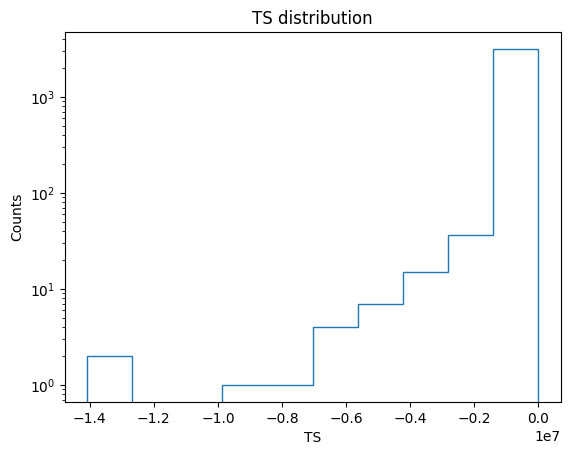

In [364]:
# for i in range(1, len(all_TSS)):
plt.figure()
histdetails = plt.hist(np.ravel(all_TSS[:]), bins=10, density=False, histtype='step')
# plt.ylim(0, 1000)
plt.yscale('log')
plt.xlabel('TS')
plt.ylabel('Counts')
plt.title('TS distribution')
plt.show()

histdetails = np.histogram(np.ravel(all_TSS[1:]), bins=10)

In [365]:
histdetails

(array([2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 4.000e+00,
        7.000e+00, 1.500e+01, 3.600e+01, 3.138e+03]),
 array([-1.40831247e+07, -1.26748121e+07, -1.12664994e+07, -9.85818669e+06,
        -8.44987401e+06, -7.04156133e+06, -5.63324865e+06, -4.22493597e+06,
        -2.81662329e+06, -1.40831061e+06,  2.06714791e+00]),
 [<matplotlib.patches.Polygon at 0x7f89dcde4700>])

In [366]:
max(np.ravel(all_TSS[:]))

2.06714790737094

np.count_nonzero(np.ravel(all_TSS[1:])> )

In [367]:
all_TSS = np.array(all_TSS, dtype=np.float64)

In [368]:
all_TSS.shape

(1, 4, 1000)

In [369]:
for w in range(1):
    for g in range(len(gamma_arr)):
        print(min(all_TSS[w][g]), max(all_TSS[w][g]))
        # np.savetxt(f'TS_w{w}_g{g}.txt', all_TSS[w][g])
        
    print('wt\n')

with open(altier_path[0] + f'all_TSS_{len(enus)}_bins.pkl', 'wb') as f:
    pickle.dump(all_TSS, f)

-14083124.732948909 1.7548252434346594
-14083124.732948909 1.7548252434346594
-7745027.109535488 2.06714790737094
-8650001.423663571 2.001087721956613
wt



In [370]:
#Plotting

all_TSS = np.asarray(all_TSS)
gamma_arr = np.asarray(gamma_arr)

all_e_UL = []
e_decade = [1e13, 1e14, 1e15, 1e16, 1e17]
for e_UL in e_decade:
    e2dfde = []

    for gamma in prange(len(gamma_arr)):
        temp = []
        for phi in range(len(phio)):
            temp.append( e_UL**2 * dfde(e_UL, gamma_arr[gamma], phio[phi]))        #in eV
        e2dfde.append(temp)
    e2dfde = np.asarray(e2dfde)

    all_e_UL.append(e2dfde)
mark = ['^', 'o', 's', 'd']

In [371]:
print(len(all_e_UL))

5


In [372]:
for i in all_e_UL:
    print(i)
    print('next energy bin')

[[1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
  9.59360829e+07 1.00000000e+08]
 [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
  9.59360829e+07 1.00000000e+08]
 [3.38844156e-10 3.53197823e-10 3.68159521e-10 ... 3.11863080e+08
  3.25073810e+08 3.38844156e+08]
 [1.00000000e-09 1.04236067e-09 1.08651577e-09 ... 9.20373200e+08
  9.59360829e+08 1.00000000e+09]]
next energy bin
[[1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
  9.59360829e+07 1.00000000e+08]
 [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
  9.59360829e+07 1.00000000e+08]
 [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
  9.59360829e+07 1.00000000e+08]
 [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
  9.59360829e+07 1.00000000e+08]]
next energy bin
[[1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
  9.59360829e+07 1.00000000e+08]
 [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
  9.59360

In [373]:

all_e_UL=np.asarray(all_e_UL)

In [374]:
print(all_e_UL)

[[[1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
   9.59360829e+07 1.00000000e+08]
  [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
   9.59360829e+07 1.00000000e+08]
  [3.38844156e-10 3.53197823e-10 3.68159521e-10 ... 3.11863080e+08
   3.25073810e+08 3.38844156e+08]
  [1.00000000e-09 1.04236067e-09 1.08651577e-09 ... 9.20373200e+08
   9.59360829e+08 1.00000000e+09]]

 [[1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
   9.59360829e+07 1.00000000e+08]
  [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
   9.59360829e+07 1.00000000e+08]
  [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
   9.59360829e+07 1.00000000e+08]
  [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
   9.59360829e+07 1.00000000e+08]]

 [[1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
   9.59360829e+07 1.00000000e+08]
  [1.00000000e-10 1.04236067e-10 1.08651577e-10 ... 9.20373200e+07
   9.59360829e+07 1.

In [375]:
all_TSS.shape

(1, 4, 1000)

In [376]:
for w in range(1):
    for g in range(0,4):
        print(phio[np.argmax(all_TSS[w][g])])

7.3259654282152e-24
7.3259654282152e-24
2.3898925662310525e-24
4.184288507901576e-25


In [291]:
max(all_TSS[0][1])

1.7548252434346594

In [342]:
tete = np.float64('2.543345761304638e-23 9.396648314954749e-24 1.4526539259467783e-24 2.3408272761782943e-23 8.296958520834915e-24 1.2305240043592616e-24 1.61141427725301e-23 5.711586478126447e-24 8.470868266557419e-25'.split(' '))

In [343]:
tete[2::3].mean()

1.1767549189872607e-24

In [377]:
# e2dfde = all_e_UL[1][2]
# dist_g25 = interp.interp1d(all_TSS[1][2], e2dfde/1e9)

# print(dist_g25(-3.84))

all_UL = []
for ws in range(1):
    ul_all_gamma = []
    for gamma in prange(len(gamma_arr)):
        temp = []
        for i in all_e_UL:
            #print(len(all_TSS[ws][gamma]))
            print(len(i[gamma]/1e9))
            dist_g = interp.interp1d(all_TSS[ws][gamma], i[gamma]/1e9)
            print()
            temp.append(dist_g(-3.84))

        ul_all_gamma.append(temp)
    all_UL.append(ul_all_gamma)
all_UL[0]

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000

1000



[[array(1.77673411e-08),
  array(1.77673411e-08),
  array(1.77673411e-08),
  array(1.77673411e-08),
  array(1.77673411e-08)],
 [array(1.77673411e-08),
  array(1.77673411e-08),
  array(1.77673411e-08),
  array(1.77673411e-08),
  array(1.77673411e-08)],
 [array(2.11712486e-08),
  array(6.24807842e-09),
  array(1.84393867e-09),
  array(5.44184881e-10),
  array(1.60600344e-10)],
 [array(1.05867911e-08),
  array(1.05867911e-09),
  array(1.05867911e-10),
  array(1.05867911e-11),
  array(1.05867911e-12)]]

In [378]:
flux_icecube_measure=4.98e-8
flux_icecube_measure_low=4.17e-8
flux_icecube_measure_high=5.73e-8


TS_vs_E2dfde_all_w_model_bins=1000000.png
DONE


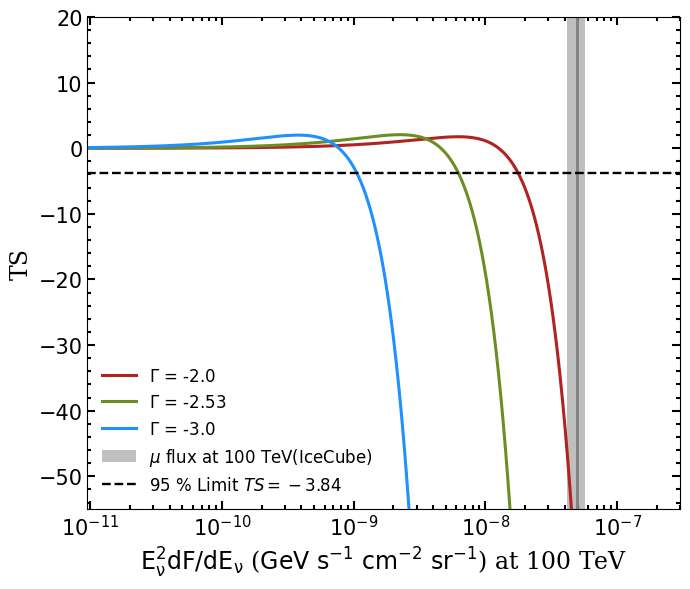

In [379]:
e2dfde = all_e_UL[1]
# plt.style.use('default')
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 17,
        }
minor_x_array=np.logspace(-12,-6,50)
fig, axs = plt.subplots(1,1, figsize=(7, 6))
c_arr=['o','firebrick','olivedrab','dodgerblue']
for gamma in [ 1, 2, 3]:#range(4):
    
#     for i in range(1):
        axs.plot(e2dfde[gamma]/1e9, all_TSS[0][gamma], label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2,c=c_arr[gamma])# + ' with wt')    #in GeV

    

        # axs.set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)
# axs[1].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$' , fontdict=smallerfont)
# axs[2].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = s_{1400}}}$', fontdict=smallerfont)
axs.axvspan(flux_icecube_measure_low, flux_icecube_measure_high, facecolor ='grey', alpha = 0.5,linewidth=3,label='$\mu$ flux at 100 TeV(IceCube)') 
axs.vlines(flux_icecube_measure,  -55, 20, lw=2, color='grey')
# for i in range(3):
    
# axs.text(1e-8,0.6,'95 % UPPER LIMIT $TS = -3.84$')    
# axs.annotate('95 % UPPER LIMIT $TS = -3.84$',xy=(0.6,0.6),xytext=(0.8,0.8), arrowprops=dict(facecolor='black',shrink=0.6,width=2))
axs.set_xlabel('$\mathsf{{E^2_{\u03BD} {dF/}{dE_{\u03BD}}}}$ ($\mathsf{{GeV}}$ $\mathsf{{s^{-1}}}$ $\mathsf{{cm^{-2}}}$ $\mathsf{{sr^{-1}}}$) at 100 TeV', fontdict=axesfont)
axs.set_ylabel('TS', fontdict=axesfont)
axs.xaxis.set_tick_params(labelsize=15)
axs.yaxis.set_tick_params(labelsize=15)
axs.tick_params(which='major', width=1.5, length=6,direction='in')
axs.tick_params(which='minor', width=1.5, length=3,direction='in')
axs.set_ylim(-55, 20)
axs.set_xlim(0.95e-11, 3e-7)
#axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params(which='minor', length=3, color='k')
# axs.set_xscale('log')
axs.tick_params(axis='x', which='minor', bottom=True,top=True)
axs.tick_params(axis='x', which='major', bottom=True,top=True)
axs.tick_params(axis='y', which='minor', right=True)
axs.tick_params(axis='y', which='major', right=True)
axs.hlines(-3.84,  0.95e-11, 3e-7,linestyles='dashed', lw=1.7, ls='--', label='95 % Limit $TS = -3.84$', color='k')
# axs.xaxis.set_minor_locator(FixedLocator(minor_x_array))
# axs.xaxis.set_minor_formatter(NullFormatter())
#plt.suptitle('TS vs Total Neutrino Flux at 100 TeV', fontweight='bold', fontsize=16, fontfamily='serif')
axs.legend(prop={'size':12}, framealpha=0)
axs.set_xscale('log')
# axs.set_yscale('log')
plt.tight_layout()
# plt.legend()
plt.savefig(f'outputs1/TS_vs_E2dfde_all_w_model_binskm2a={len(enus)}.pdf')
# plt.show()
print(f'\nTS_vs_E2dfde_all_w_model_bins={len(enus)}.png\nDONE')

In [380]:
gama=list(np.random.normal(2.53,0.07,100))
Phi=list(np.random.normal(1.66,0.25,100))
all_e_UL = []
e_decade = [1e13, 1e14, 1e15, 1e16, 1e17]
x = np.logspace(13.2041, 15.41497, 50)
x=list(x)
# print(x)
e2dfde = []
e_UL_GeV=[]
def model(xm,gm,ph):
    '''
    Parameters
    ----------
    e_nu : float
        The neutrino energy in eV
    
    gamma : float
        The spectral index of the neutrino flux
    
    phi0 : float (optional)
        The normalization constant of the neutrino flux in eV^-1. The default is 1e-40.
    
    Returns
    -------
    float
        The differential flux of neutrinos
    '''
    e2dfde = []
    for e_UL in xm:
    
    # e_UL_GeV.append(e_UL*1e-9)
    # for gamma in prange(len(gamma_arr)):
    # temp = []
    # for phi in range(len(phio)):
    

        e2dfde.append(3e-18*(e_UL*1e-9)**2 * ph * ((e_UL/(10**14))**(-1*gm)))        #in eV
    # e2dfde.append(temp)
    e2dfde = np.asarray(e2dfde)
    return e2dfde      #eV^-1

    # all_e_UL.append(e2dfde)

In [381]:
ysample=np.asarray([model(x,gama[i],Phi[i]) for i in range(len(gama))])

In [382]:
lower=np.percentile(ysample,(100-68.26)/2,axis=0)
upper=np.percentile(ysample,(100-68.26)/2+68.26,axis=0)

In [351]:
len(lower)

50

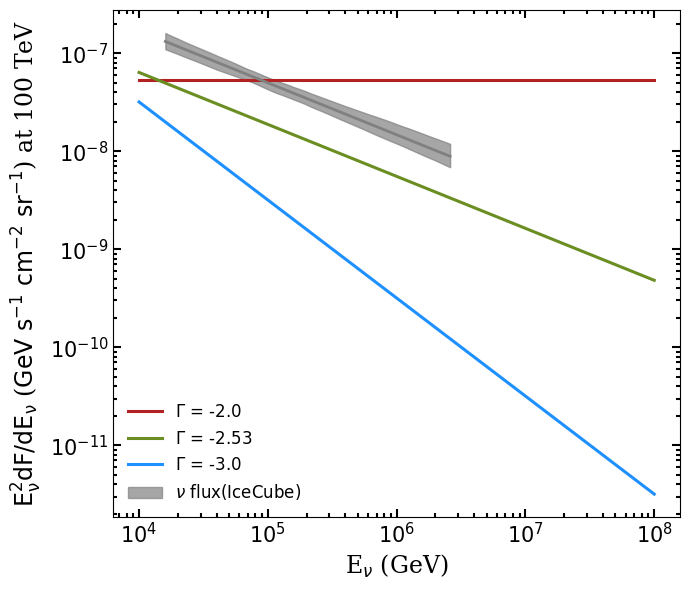

In [383]:
fig, axs = plt.subplots(1,1, figsize=(7, 6))
minor_y_array=np.logspace(-12,-6,50)
for gamma in range(1, len(gamma_arr)):

    axs.plot(np.divide(e_decade, 1e9), np.multiply(all_UL[0][gamma], 3), label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2, ls='-',c=c_arr[gamma])# + ' with wt')    #in GeV
    

axs.set_xlabel('E$_{\u03BD}$ (GeV)', fontdict=axesfont)
axs.set_ylabel('$\mathsf{{E^2_{\u03BD} {dF/}{dE_{\u03BD}}}}$ ($\mathsf{{GeV}}$ $\mathsf{{s^{-1}}}$ $\mathsf{{cm^{-2}}}$ $\mathsf{{sr^{-1}}}$) at 100 TeV', fontdict=axesfont)
axs.xaxis.set_tick_params(labelsize=15)
axs.yaxis.set_tick_params(labelsize=15)
axs.tick_params(which='major', width=1.5, length=6,direction='in')
axs.tick_params(which='minor', width=1.5, length=3,direction='in')

#axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params(which='minor', length=3, color='k')
# axs.set_xscale('log')
axs.tick_params(axis='x', which='minor', bottom=True,top=True)
axs.tick_params(axis='x', which='major', bottom=True,top=True)
axs.tick_params(axis='y', which='minor', right=True)
axs.tick_params(axis='y', which='major', right=True)
# axs.yaxis.set_minor_locator(FixedLocator(minor_y_array))
# axs.yaxis.set_minor_formatter(NullFormatter())
axs.legend(prop={'size':14}, framealpha=0, loc='lower left')

#x = np.linspace(e_decade[:-2][0], e_decade[1:-1][-1], 11)
# x=x*1e-9
# y = [3.9, 4.4, 10.8, 10.3, 11.2, 13.1, 14.1,  9.9, 13.9, 15.1, 12.5]

# fit a linear curve and estimate its y-values and their error.
# a, b = np.polyfit(x, y, deg=1)
# y_est = 3e-18*x*x*1.66* np.divide(x,1e5)**(-2.53)
# y_est_up =3e-18*x*x*1.91* np.divide(x,1e5)**(-2.60)
# y_est_low =3e-18*x*x*1.39* np.divide(x,1e5)**(-2.46)
# y_err = np.divide(x, 1e9).std() * np.sqrt(1/len(x) +
#                           (np.divide(x, 1e9) - np.divide(x, 1e9).mean())**2 / np.sum((np.divide(x, 1e9) - np.divide(x, 1e9).mean())**2))


axs.plot(np.divide(x,1e9), model(x,2.53,1.66), '-',c='grey',linewidth=2)

# axs.plot(x, y_est_low, '-',c='grey',linewidth=1)
# axs.plot(x, y_est_up, '-',c='grey',linewidth=1)
axs.fill_between(np.divide(x,1e9),lower, upper, color='grey',alpha=0.7,label='$\\nu$ flux(IceCube)')
# axs.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)

# axs.plot(x, y, 'o', color='tab:brown')
# axs[0].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = 1}}$', fontdict=smallerfont)
# axs[1].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = \dfrac{1}{d_{DM}^2}}}$' , fontdict=smallerfont)
# axs[2].set_title('Weighting scheme: $\mathsf{\mathbf{w_{acc}}}$; $\mathsf{\mathbf{w_{model} = s_{1400}}}$', fontdict=smallerfont)
axs.legend(prop={'size':12}, framealpha=0)

# axs.set_ylim(4e-9, 3e-7)
# axs.set_xlim(1e4, 1e8)
axs.set_xscale('log')
axs.set_yscale('log')
# plt.suptitle('95% UL of Total Energy Flux vs Neutrino Energy', fontweight='bold', fontsize=20, fontfamily='serif')
plt.tight_layout()
plt.savefig(f'outputs1/UL_all_w_model_binskm2a={len(enus)}.pdf')
plt.show()


In [78]:
np.divide(e_decade, 1e9)*np.divide(e_decade, 1e9)*1.66*np.divide(e_decade,1e14)**-2.53

array([5.62481299e+10, 1.66000000e+10, 4.89900732e+09, 1.44579956e+09,
       4.26685700e+08])

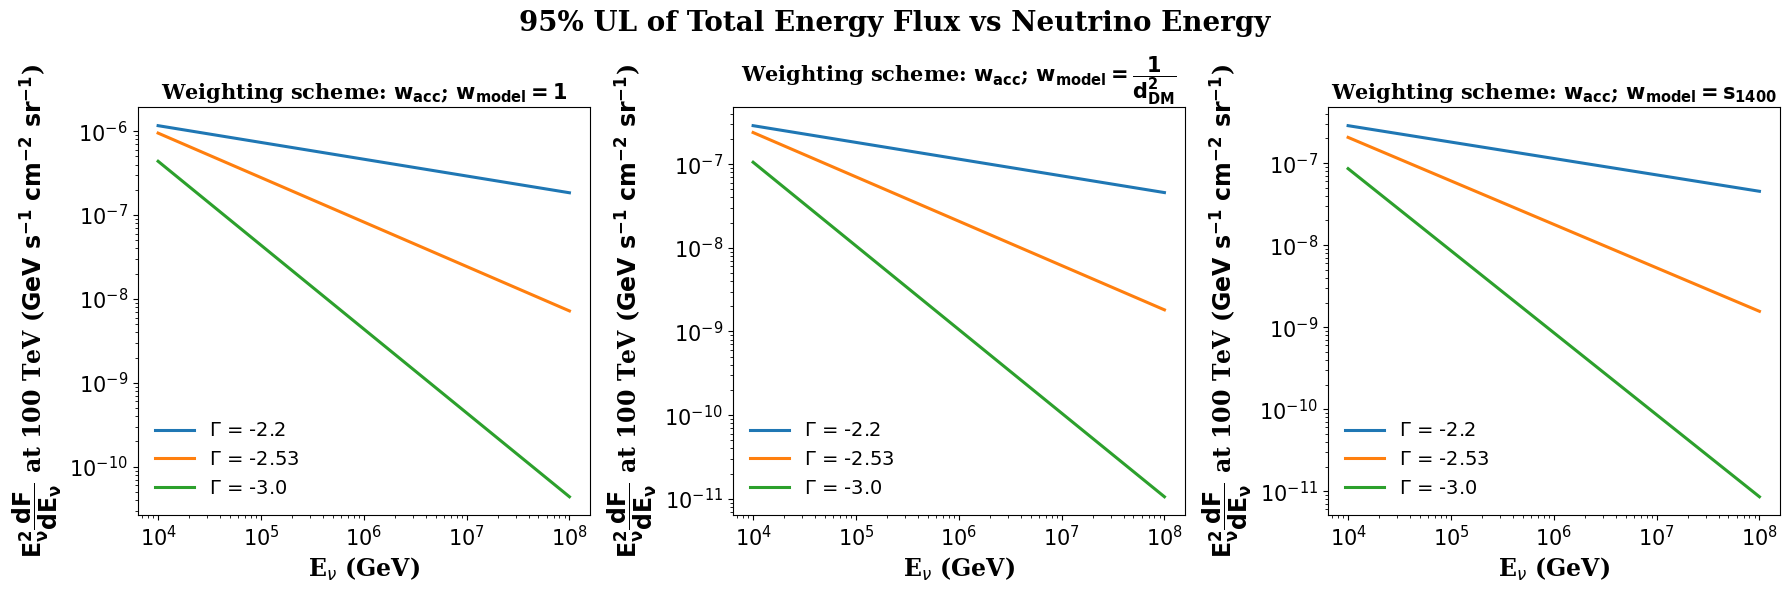

In [58]:
#SIMILAR PLOTS FOR 95% UPPER LIMIT 
fig, axs = plt.subplots(1,3, figsize=(18, 6))



for gamma in range(1, len(gamma_arr)):

    axs[i].plot(np.divide(e_decade, 1e9), np.multiply(all_UL[i][gamma], 3), label='$\Gamma$ = ' + str(gamma_arr[gamma]), lw=2.2, ls='-')# + ' with wt')    #in GeV


    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.set_xlabel('E$_{\u03BD}$ (GeV)', fontdict=axesfont)
    axs.set_ylabel('$\mathsf{\mathbf{E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}}}$ at 100 TeV ($\mathsf{\mathbf{GeV}}$ $\mathsf{\mathbf{s^{-1}}}$ $\mathsf{\mathbf{cm^{-2}}}$ $\mathsf{\mathbf{sr^{-1}}}$)', fontdict=axesfont)
    axs.xaxis.set_tick_params(labelsize=15)
    axs.yaxis.set_tick_params(labelsize=15)
    
    axs[i].legend(prop={'size':14}, framealpha=0, loc='lower left')


# plt.suptitle('95% UL of Total Energy Flux vs Neutrino Energy', fontweight='bold', fontsize=20, fontfamily='serif')
plt.tight_layout()
# plt.savefig(f'outputs1/UL_all_w_model_bins={len(enus)}.pdf')
plt.show()


In [294]:
# e2dfde = all_e_UL[1]
# plttitles = ['$w_{acc}$ and $w_{model} = 1$', '$w_{acc}$ and $w_{model} = \dfrac{1}{d_{DM}^2}$', '$w_{acc}$ and $w_{model} =  w_{s1400}$']

#         # print(st.t.interval(0.95, len(all_TSS[i][j])-1, loc=np.mean(all_TSS[i][j]), scale=st.sem(all_TSS[i][j])))
# for i in range(1, 4):
#     plt.figure(figsize=(8, 6))
#     for j in range(1, len(gamma_arr)):
#         plt.plot(e2dfde[j]/1e9, all_TSS[i][j], label='$\Gamma$ = ' + str(gamma_arr[j]), lw=0.8)
#         # ci = st.t.interval(0.95, len(all_TSS[i][j])-1, loc=np.mean(all_TSS[i][j]), scale=st.sem(all_TSS[i][j]))
#         # plt.hlines(ci, 1e-19, 1e-6, colors='k', linestyles='dashed', lw=0.5, ls='-.', label="95% CI "+ '$\Gamma$ = ' + str(gamma_arr[j]))

#     plt.hlines(-3.84, 1e-19, 1e-6, linestyles='dashed', lw=0.7, ls='-.', label='95 % UPPER LIMIT $TS = -3.84$')
#     # plt.vlines(dist_g25(-3.84), -120, 50, linestyles='dashed', lw=0.5, ls='-.')
#     plt.legend()
#     plt.xscale('log')
#     # plt.yscale('log')
#     plt.xlabel("$E^2_{\u03BD} \dfrac{dF}{dE_{\u03BD}}$ (GeV)")
#     plt.ylabel(r'$TS$')
#     plt.ylim(-200, 50)
#     plt.title("TS vs Total Neutrino Flux at 100 TeV\nWeighting scheme: " + plttitles[i-1])
#     plt.savefig(os.getcwd() + f'/outputs/TSvsE2dFdE_ws_{i}.png', facecolor='w')
#     plt.show()

In [295]:
import matplotlib.pyplot as plt
from scipy import interpolate
x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = interpolate.interp1d(x, y)

In [221]:
import numpy as np
from scipy.optimize import curve_fit
import uncertainties as unc
import matplotlib.pyplot as plt
import uncertainties.unumpy as unp


def func(x, a, b, c):
    '''Exponential 3-param function.'''
    return a * np.exp(b * x) + c

x, y = np.genfromtxt('data.txt', unpack=True)

popt, pcov = curve_fit(func, x, y)

a, b, c = unc.correlated_values(popt, pcov)

# Plot data and best fit curve.
plt.scatter(x, y, s=3, linewidth=0, alpha=0.3)

px = np.linspace(11, 23, 100)
# use unumpy.exp
py = a * unp.exp(b * px) + c

nom = unp.nominal_values(py)
std = unp.std_devs(py)

# plot the nominal value
plt.plot(px, nom, c='r')

# And the 2sigma uncertaintie lines
plt.plot(px, nom - 2 * std, c='c')
plt.plot(px, nom + 2 * std, c='c')
plt.savefig('fit.png', dpi=300)

ModuleNotFoundError: No module named 'uncertainties'

In [54]:
import os
import numpy as np
path='/home/sjtu/Downloads/asciidataof_fig1/32lag/'
namefile=os.listdir(path)
namefile.sort(key=lambda x:int(x[3:9]))
namefile.reverse()
print(namefile)

['GRB210619B.txt', 'GRB210610B.txt', 'GRB210204A.txt', 'GRB201216C.txt', 'GRB200829A.txt', 'GRB200613A.txt', 'GRB190114C.txt', 'GRB180720B.txt', 'GRB180703A.txt', 'GRB171010A.txt', 'GRB160625B.txt', 'GRB160509A.txt', 'GRB150821A.txt', 'GRB150514A.txt', 'GRB150403A.txt', 'GRB150314A.txt', 'GRB141028A.txt', 'GRB140508A.txt', 'GRB140206A.txt', 'GRB131231A.txt', 'GRB131108A.txt', 'GRB130925A.txt', 'GRB130518A.txt', 'GRB130427A.txt', 'GRB120119A.txt', 'GRB100728A.txt', 'GRB091003A.txt', 'GRB090926A.txt', 'GRB090618.txt', 'GRB090328.txt', 'GRB081221.txt', 'GRB080916C.txt']


In [77]:
loge3bound=np.linspace(np.log10(10),np.log10(400),25)
in3=list(10**loge3bound)
for j in range(len(in3)):
       in3[j]=round(in3[j],0)
print(in3[1:])

[12.0, 14.0, 16.0, 18.0, 22.0, 25.0, 29.0, 34.0, 40.0, 47.0, 54.0, 63.0, 74.0, 86.0, 100.0, 117.0, 136.0, 159.0, 185.0, 216.0, 252.0, 294.0, 343.0, 400.0]


In [114]:
loge1bound=np.linspace(np.log10(10),np.log10(11000),25)
in1=list(10**loge1bound)
for j in range(len(in1)):
       in1[j]=round(in1[j],0)
in1=in1[1:]
loge2bound=np.linspace(np.log10(30),np.log10(380),23)
in2=list(10**loge2bound)
for j in range(len(in2)):
       in2[j]=round(in2[j],0)
in2=in2[1:]
loge3bound=np.linspace(np.log10(10),np.log10(400),24)
in3=list(10**loge3bound)
for j in range(len(in3)):
       in3[j]=round(in3[j],0)
in3=in3[1:]
loge4bound=np.linspace(np.log10(15),np.log10(700),22)
in4=list(10**loge4bound)
for j in range(len(in4)):
       in4[j]=round(in4[j],0)
in4=in4[1:]
loge5bound=np.linspace(np.log10(25),np.log10(3500),25)
in5=list(10**loge5bound)
for j in range(len(in5)):
       in5[j]=round(in5[j],0)
in5=in5[1:]
loge6bound=np.linspace(np.log10(30),np.log10(300),23)
in6=list(10**loge6bound)
for j in range(len(in6)):
       in6[j]=round(in6[j],0)
in6=in6[1:]
loge7bound=np.linspace(np.log10(10),np.log10(5000),22)
in7=list(10**loge7bound)
for j in range(len(in7)):
       in7[j]=round(in7[j],0)
in7=in7[1:]
loge8bound=np.linspace(np.log10(25),np.log10(17000),18)
in8=list(10**loge8bound)
for j in range(len(in8)):
       in8[j]=round(in8[j],0)
in8=in8[1:]
loge9bound=np.linspace(np.log10(20),np.log10(400),20)
in9=list(10**loge9bound)
for j in range(len(in9)):
       in9[j]=round(in9[j],0)
in9=in9[1:]
loge10bound=np.linspace(np.log10(10),np.log10(620),26)
in10=list(10**loge10bound)
for j in range(len(in10)):
       in10[j]=round(in10[j],0)
in10=in10[1:]
loge11bound=np.linspace(np.log10(10),np.log10(20000),37)
in11=list(10**loge11bound)
for j in range(len(in11)):
       in11[j]=round(in11[j],0)
in11=in11[1:]
loge12bound=np.linspace(np.log10(10),np.log10(800),20)
in12=list(10**loge12bound)
for j in range(len(in12)):
       in12[j]=round(in12[j],0)
in12=in12[1:]
loge13bound=np.linspace(np.log10(10),np.log10(280),22)
in13=list(10**loge13bound)
for j in range(len(in13)):
       in13[j]=round(in13[j],0)
in13=in13[1:]
loge14bound=np.linspace(np.log10(20),np.log10(200),16)
in14=list(10**loge14bound)
for j in range(len(in14)):
       in14[j]=round(in14[j],0)
in14=in14[1:]
loge15bound=np.linspace(np.log10(35),np.log10(700),19)
in15=list(10**loge15bound)
for j in range(len(in15)):
       in15[j]=round(in15[j],0)
in15=in15[1:]
loge16bound=np.linspace(np.log10(20),np.log10(800),25)
in16=list(10**loge16bound)
for j in range(len(in16)):
       in16[j]=round(in16[j],0)
in16=in16[1:]
loge17bound=np.linspace(np.log10(40),np.log10(400),20)
in17=list(10**loge17bound)
for j in range(len(in17)):
       in17[j]=round(in17[j],0)
in17=in17[1:]
loge18bound=np.linspace(np.log10(10),np.log10(720),20)
in18=list(10**loge18bound)
for j in range(len(in18)):
       in18[j]=round(in18[j],0)
in18=in18[1:]
loge19bound=np.linspace(np.log10(20),np.log10(320),17)
in19=list(10**loge19bound)
for j in range(len(in19)):
       in19[j]=round(in19[j],0)
in19=in19[1:]
loge20bound=np.linspace(np.log10(10),np.log10(713),25)
in20=list(10**loge20bound)
for j in range(len(in20)):
       in20[j]=round(in20[j],0)
in20=in20[1:]
loge21bound=np.linspace(np.log10(20),np.log10(500),19)
in21=list(10**loge21bound)
for j in range(len(in21)):
       in21[j]=round(in21[j],0)
in21=in21[1:]
loge22bound=np.linspace(np.log10(10),np.log10(300),19)
in22=list(10**loge22bound)
for j in range(len(in22)):
       in22[j]=round(in22[j],0)
in22=in22[1:]
loge23bound=np.linspace(np.log10(10),np.log10(1200),18)
in23=list(10**loge23bound)
for j in range(len(in23)):
       in23[j]=round(in23[j],0)
in23=in23[1:]
loge24bound=np.linspace(np.log10(10),np.log10(5000),30)
in24=list(10**loge24bound)
for j in range(len(in24)):
       in24[j]=round(in24[j],0)
in24=in24[1:]
loge25bound=np.linspace(np.log10(25),np.log10(500),16)
in25=list(10**loge25bound)
for j in range(len(in25)):
       in25[j]=round(in25[j],0)
in25=in25[1:]
loge26bound=np.linspace(np.log10(40),np.log10(400),19)
in26=list(10**loge26bound)
for j in range(len(in26)):
       in26[j]=round(in26[j],0)
in26=in26[1:]
loge27bound=np.linspace(np.log10(10),np.log10(800),18)
in27=list(10**loge27bound)
for j in range(len(in27)):
       in27[j]=round(in27[j],0)
in27=in27[1:]
loge28bound=np.linspace(np.log10(10),np.log10(800),23)
in28=list(10**loge28bound)
for j in range(len(in28)):
       in28[j]=round(in28[j],0)
in28=in28[1:]
loge29bound=np.linspace(np.log10(10),np.log10(700),22)
in29=list(10**loge29bound)
for j in range(len(in29)):
       in29[j]=round(in29[j],0)
in29=in29[1:]
loge30bound=np.linspace(np.log10(30),np.log10(500),20)
in30=list(10**loge30bound)
for j in range(len(in30)):
       in30[j]=round(in30[j],0)
in30=in30[1:]
loge31bound=np.linspace(np.log10(10),np.log10(300),19)
in31=list(10**loge31bound)
for j in range(len(in31)):
       in31[j]=round(in31[j],0)
in31=in31[1:]
loge32bound=np.linspace(np.log10(10),np.log10(600),20)
in32=list(10**loge32bound)
for j in range(len(in32)):
       in32[j]=round(in32[j],0)
in32=in32[1:]




In [117]:
print(in1)

[13.0, 18.0, 24.0, 32.0, 43.0, 58.0, 77.0, 103.0, 138.0, 185.0, 248.0, 332.0, 444.0, 594.0, 796.0, 1066.0, 1427.0, 1910.0, 2557.0, 3424.0, 4584.0, 6137.0, 8216.0, 11000.0]


In [107]:
interval=[in1,in2,in3,in4,in5,in6,in7,in8,in9,in10,in11,in12,in13,in14,in15,in16,in17,in18,in19,in20,in21,in22,in23,in24,in25,in26,in27,in28,in29,in30,in31,in32]
print(len(interval[10][:-1]))

35


In [116]:
E=np.loadtxt(path+namefile[0],usecols=(0),unpack=True)
E_errlow=E-interval[0][:-1]
E_errhigh=interval[0][1:]-E
print(E_errlow,E_errhigh)

[   2.5    3.     4.     5.5    7.5    9.5   13.    17.5   23.5   31.5
   42.    56.    75.   101.   135.   180.5  241.5  323.5  433.5  580.
  776.5 1039.5 1392. ] [   2.5    3.     4.     5.5    7.5    9.5   13.    17.5   23.5   31.5
   42.    56.    75.   101.   135.   180.5  241.5  323.5  433.5  580.
  776.5 1039.5 1392. ]


In [66]:
print(namefile)

['GRB210619B.txt', 'GRB210610B.txt', 'GRB210204A.txt', 'GRB201216C.txt', 'GRB200829A.txt', 'GRB200613A.txt', 'GRB190114C.txt', 'GRB180720B.txt', 'GRB180703A.txt', 'GRB171010A.txt', 'GRB160625B.txt', 'GRB160509A.txt', 'GRB150821A.txt', 'GRB150514A.txt', 'GRB150403A.txt', 'GRB150314A.txt', 'GRB141028A.txt', 'GRB140508A.txt', 'GRB140206A.txt', 'GRB131231A.txt', 'GRB131108A.txt', 'GRB130925A.txt', 'GRB130518A.txt', 'GRB130427A.txt', 'GRB120119A.txt', 'GRB100728A.txt', 'GRB091003A.txt', 'GRB090926A.txt', 'GRB090618.txt', 'GRB090328.txt', 'GRB081221.txt', 'GRB080916C.txt']


In [118]:
for i in range(len(namefile)):
    # print(i)
    E=np.loadtxt(path+namefile[i],usecols=(0),unpack=True)
    print(E.shape)
    print(len(interval[i][:-1]))
    E_errlow=E-interval[i][:-1]
    E_errhigh=interval[i][1:]-E
    lag=np.loadtxt(path+namefile[i],usecols=(1),unpack=True)
    lagerr=np.loadtxt(path+namefile[i],usecols=(2),unpack=True)
    # if not os.path.exists('/home/sjtu/Downloads/asciidataof_fig1/'+namefile[i]):
    #     os.makedirs('/home/sjtu/Downloads/asciidataof_fig1/'+namefile[i])
    with open ('/home/sjtu/Downloads/asciidataof_fig1/'+namefile[i],'a+') as f:
        for j in range(len(E)):
                f.write(str(E[j]))
                f.write(str('   '))
                f.write(str(E_errlow[j]))
                f.write(str('   '))
                f.write(str(lag[j]))
                f.write(str('   '))
                f.write(str(lagerr[j]))
                f.write('\n')
        f.close()


(23,)
23
(21,)
21
(22,)
22
(20,)
20
(23,)
23
(21,)
21
(20,)
20
(16,)
16
(18,)
18
(24,)
24
(35,)
35
(18,)
18
(20,)
20
(14,)
14
(17,)
17
(23,)
23
(18,)
18
(18,)
18
(15,)
15
(23,)
23
(17,)
17
(17,)
17
(16,)
16
(28,)
28
(14,)
14
(17,)
17
(16,)
16
(21,)
21
(20,)
20
(18,)
18
(17,)
17
(18,)
18
